# Imports

In [2]:
import pandas as pd
from pathlib import Path
import os
import plotly.express as px
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import LeaveOneOut
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import cross_val_score
import seaborn as sns  # Opcional, para estilização
from sklearn.metrics import explained_variance_score

# Obtenção dos dados

In [3]:
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))

# Definindo o caminho base para a pasta Pre-processamento
base_path = Path(parent_dir) / 'Partial Components Analysis'

file_path_raw_cal = base_path / 'RAW_calibration.xlsx'
file_path_msc_cal = base_path / 'MSC_calibration.xlsx'
file_path_snv_cal = base_path / 'SNV_calibration.xlsx'
file_path_sg_cal = base_path / 'SG_calibration.xlsx'

df_raw_cal = pd.read_excel(file_path_raw_cal)
df_msc_cal = pd.read_excel(file_path_msc_cal)
df_snv_cal = pd.read_excel(file_path_snv_cal)
df_sg_cal = pd.read_excel(file_path_sg_cal)

file_path_raw_val = base_path / 'RAW_validation.xlsx'
file_path_msc_val = base_path / 'MSC_validation.xlsx'
file_path_snv_val = base_path / 'SNV_validation.xlsx'
file_path_sg_val = base_path / 'SG_validation.xlsx'

df_raw_val = pd.read_excel(file_path_raw_val)
df_msc_val = pd.read_excel(file_path_msc_val)
df_snv_val = pd.read_excel(file_path_snv_val)
df_sg_val = pd.read_excel(file_path_sg_val)

# Implementação

In [9]:
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import LeaveOneOut, cross_val_predict
from sklearn.metrics import r2_score, mean_squared_error, explained_variance_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def train_model(X_scaled, Y_scaled):
    max_lv = 10
    lvs = []
    k=1
    loo = LeaveOneOut()
    
    calibration = pd.DataFrame(index=range(1, max_lv + 1), columns=['r2_cal', 'neg_root_mean_squared_error_cal', 'explained_variance_cal', 'correlation_cal', 'rpearson_cal', 'secv_cal'])
    validation = pd.DataFrame(index=range(1, max_lv + 1), columns=['r2_cv', 'neg_root_mean_squared_error_cv', 'explained_variance_cv', 'correlation_cv', 'rpearson_cv', 'secv_cv'])
    
    Y_values = pd.DataFrame(index=range(len(Y_scaled)))
    Y_values['Referencia'] = Y_scaled.flatten()  # Valores reais de Y
        
    for lv in range(1, max_lv + 1):
        pca = PCA(n_components=lv)
        X_pca = pca.fit_transform(X_scaled)
        lin_reg = LinearRegression()

        # Calibração do modelo
        lin_reg.fit(X_pca, Y_scaled)
        predictions_train = lin_reg.predict(X_pca)

        # Calcula as métricas para a fase de calibração
        calibration.loc[lv, 'r2_cal'] = r2_score(Y_scaled, predictions_train)
        calibration.loc[lv, 'neg_root_mean_squared_error_cal'] = np.sqrt(mean_squared_error(Y_scaled, predictions_train))
        calibration.loc[lv, 'explained_variance_cal'] = explained_variance_score(Y_scaled, predictions_train)

        # Garantir que Y_scaled e predictions_train sejam arrays bidimensionais
        if Y_scaled.ndim == 1:
            Y_scaled = Y_scaled.reshape(-1, 1)
        if predictions_train.ndim == 1:
            predictions_train = predictions_train.reshape(-1, 1)

        correlation_cal = np.corrcoef(Y_scaled[:, 0], predictions_train[:, 0])[0, 1]  # Correlação
        calibration.loc[lv, 'correlation_cal'] = correlation_cal

        # Calcular rpearson para calibração
        rpearson_cal = correlation_cal ** 2
        calibration.loc[lv, 'rpearson_cal'] = rpearson_cal

        # Calcular o viés para calibração
        bias_cal = np.mean(predictions_train - Y_scaled)
        calibration.loc[lv, 'bias_cal'] = bias_cal

        # Calcular SE (Standard Error) para calibração
        sec_cal = np.sqrt(mean_squared_error(Y_scaled, predictions_train))
        calibration.loc[lv, 'sec_cal'] = sec_cal
        
        # Adicionar as previsões de calibração ao DataFrame Y_values
        Y_values[f'Calibracao_LV{lv}'] = predictions_train.flatten()

        # Validação cruzada (Leave-One-Out)
        predictions_cv = cross_val_predict(lin_reg, X_pca, Y_scaled, cv=loo)

        # Calcula as métricas para a validação cruzada
        validation.loc[lv, 'r2_cv'] = r2_score(Y_scaled, predictions_cv)
        validation.loc[lv, 'neg_root_mean_squared_error_cv'] = np.sqrt(mean_squared_error(Y_scaled, predictions_cv))
        validation.loc[lv, 'explained_variance_cv'] = explained_variance_score(Y_scaled, predictions_cv)

        # Garantir que predictions_cv seja array bidimensional
        if predictions_cv.ndim == 1:
            predictions_cv = predictions_cv.reshape(-1, 1)

        correlation_cv = np.corrcoef(Y_scaled[:, 0], predictions_cv[:, 0])[0, 1]  # Correlação
        validation.loc[lv, 'correlation_cv'] = correlation_cv

        # Calcular rpearson para validação cruzada
        rpearson_cv = correlation_cv ** 2
        validation.loc[lv, 'rpearson_cv'] = rpearson_cv

        # Calcular o viés para validação cruzada
        bias_cv = np.mean(predictions_cv - Y_scaled)
        validation.loc[lv, 'bias_cv'] = bias_cv

        # Calcular SECV (Standard Error of Cross Validation)
        secv_cv = np.sqrt(mean_squared_error(Y_scaled, predictions_cv))
        validation.loc[lv, 'secv_cv'] = secv_cv
        
        # Adicionar as previsões de validação ao DataFrame Y_values
        Y_values[f'Validacao_LV{lv}'] = predictions_cv.flatten()
    
               
    for j in range(1, max_lv):
        if j + 1 <= max_lv:
            rmsecv_j = validation.loc[j + 1, 'rpearson_cv']
            rmsecv_j_plus_1 = validation.loc[j, 'rpearson_cv']
            aux = rmsecv_j / rmsecv_j_plus_1
            
            if aux > 1 and ((aux - 1) * 100 >= 2):
                lvs.append(j + 1)
                k += 1
    
    if len(lvs) == 0:
        lvs.append(1)
    
    lv_num = lvs[-1]
    
    if len(lvs) > 1:
        pca = PCA(n_components=lvs[-2])
        X_pca = pca.fit_transform(X_scaled)
        lin_reg = LinearRegression()
        lin_reg.fit(X_pca, Y_scaled)

        for w in range(k - 2):
            if lin_reg.coef_.shape[0] > 3:
                if lvs[w + 1] < lin_reg.coef_.shape[0] and lin_reg.coef_[lvs[w + 1], 3] < 1:
                    lv_num = lvs[w]
                    break

        model = lin_reg.fit(X_pca, Y_scaled)
    else:
        pca = PCA(n_components=lvs[0])
        X_pca = pca.fit_transform(X_scaled)
        lin_reg = LinearRegression()
        model = lin_reg.fit(X_pca, Y_scaled)

    return calibration, validation, lv_num, model, pca, Y_values

def center_data(X, Y):
    # Calcula as médias para cada coluna
    mx = np.mean(X, axis=0)
    
    # Calcula a média para Y
    my = np.mean(Y)
    
    # Centraliza as colunas na média
    abs_centered = X - mx
    qua_centered = Y - my
       
    return abs_centered, qua_centered, mx, my

def predict(model, pca, X_pred, y_pred, lv_number):
    X_centered, _, _, _ = center_data(X_pred.iloc[:,6:].values, y_pred.values)
    X_pred_pca = pca.transform(X_centered)  # Transformar dados de teste com PCA
    
    pred = model.predict(X_pred_pca)
       
    y_pred = y_pred.values  # Convertendo Series para NumPy array
    pred = pred.reshape(-1, 1)  # Garantindo que pred seja 2D

    if y_pred.ndim == 1:
        y_pred = y_pred.reshape(-1, 1)

    Y_predict = pd.DataFrame(columns=['Amostra', 'Y_pred', 'Y_true', 'Deviation', 'RMSEP'])
    
    prediction = pd.DataFrame(columns=['r2_p', 'neg_root_mean_squared_error_p', 'explained_variance_p', 'correlation_p', 'rpearson_p', 'bias_p', 'sec_p'])
    
    prediction.loc[lv_number, 'r2_p'] = r2_score(y_pred, pred)
    prediction.loc[lv_number, 'neg_root_mean_squared_error_p'] = np.sqrt(mean_squared_error(y_pred, pred))
    prediction.loc[lv_number, 'explained_variance_p'] = explained_variance_score(y_pred, pred)
    prediction.loc[lv_number, 'correlation_p'] = np.corrcoef(y_pred[:, 0], pred[:, 0])[0, 1]
    prediction.loc[lv_number, 'rpearson_p'] = np.corrcoef(y_pred[:, 0], pred[:, 0])[0, 1] ** 2  # Quadrado do coeficiente de correlação
    prediction.loc[lv_number, 'bias_p'] = np.mean(pred - y_pred)  # Viés
    prediction.loc[lv_number, 'sec_p'] = np.sqrt(np.mean((pred - y_pred) ** 2))  # Erro quadrático de calibração
    
    Y_predict['Y_pred'] = pred.flatten()
    Y_predict['Y_true'] = y_pred.flatten()
    Y_predict['Deviation'] = pred.flatten() - y_pred.flatten()
    Y_predict['Amostra'] = X_pred.iloc[0:,0].tolist()
    Y_predict['RMSEP'] = mean_squared_error(y_pred, pred)
    
    return prediction, Y_predict

def plot_pred_vs_ref(Y_true, Y_pred, Y_opt, title="Predicted vs Reference"):
    
    slope_pred, offset_pred = np.polyfit(Y_true, Y_pred, 1)
    rmse_pred = np.sqrt(mean_squared_error(Y_true, Y_pred))
    r2_pred = r2_score(Y_true, Y_pred)
    
    slope_opt, offset_opt = np.polyfit(Y_true, Y_opt, 1)
    rmse_opt = np.sqrt(mean_squared_error(Y_true, Y_opt))
    r2_opt = r2_score(Y_true, Y_opt)
    
    plt.figure(figsize=(10, 6))
    
    # Scatter plot for reference values
    plt.scatter(Y_true, Y_opt, color='blue', label='Reference', marker='o', alpha=0.7)
    
    # Scatter plot for predicted values
    plt.scatter(Y_true, Y_pred, color='red', label='Predicted', marker='o', alpha=0.7)
       
    plt.xlabel("Reference")
    plt.ylabel("Predicted")
    plt.title(title)
    plt.grid(True)
    plt.text(0.05, 0.95, f'Reference - Slope: {slope_opt:.2f}, Offset: {offset_opt:.2f}, RMSE: {rmse_opt:.2f}, R²: {r2_opt:.2f}\nPredicted - Slope: {slope_pred:.2f}, Offset: {offset_pred:.2f}, RMSE: {rmse_pred:.2f}, R²: {r2_pred:.2f}',
             transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', horizontalalignment='left')
    plt.legend(loc='lower right')
    plt.show()

def pred_plot(Y_predict):
    plt.figure(figsize=(15, 5))
    plt.title("Predicted with Deviation")

    # Plotar cada amostra
    for sample in Y_predict.index:
        y_pred = Y_predict.loc[sample, 'Y_pred']
        deviation = Y_predict.loc[sample, 'Deviation']
        y_true = Y_predict.loc[sample, 'Y_true']
        
        # Criar os dados do boxplot para esta amostra
        data_boxplot = [y_pred - deviation, y_pred, y_pred + deviation]
        
        # Plotar o boxplot
        plt.boxplot(data_boxplot, positions=[Y_predict.index.get_loc(sample)], widths=0.6, patch_artist=True, 
                    boxprops=dict(edgecolor='blue', linewidth=1.5),
                    whiskerprops=dict(color='red'),
                    capprops=dict(color='red'),
                    medianprops=dict(color='black'))
        
    plt.xticks(ticks=range(len(Y_predict.index)), labels=Y_predict['Amostra'], rotation=90)
    plt.xlabel('Samples')
    plt.ylabel('Predicted Y (SS FT-IR factor-6)')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def build_model(X_cal, Y_cal, X_val, Y_val):
    Y_pred = Y_val
    X_pred = X_val
       
    X = X_cal
    Y = Y_cal
    
    calibration, validation, lv_num, model, pca, Y_values = train_model(X.iloc[:,6:].values, Y.values)
    print(f'Número de componentes: {lv_num}')
        
    prediction, Y_predict = predict(model, pca, X_pred, Y_pred, lv_num)
    
    Y_true = Y_values.iloc[:, 0]  # Primeira coluna de Y_values
    Y_opt = Y_values[f'Calibracao_LV{lv_num}']  # Coluna específica de calibração
    Y_pred = Y_values[f'Validacao_LV{lv_num}']  # Coluna específica de validação
    plot_pred_vs_ref(Y_true, Y_pred, Y_opt)  
    pred_plot(Y_predict)
    
    return calibration, validation, Y_predict


In [6]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import LeaveOneOut, cross_val_predict
from sklearn.metrics import r2_score, mean_squared_error, explained_variance_score

# Função para centralizar os dados
def mean_centering(data):
    numeric_data = pd.DataFrame(data).apply(pd.to_numeric, errors='coerce')  # Convertendo valores não numéricos para NaN
    centered_data = numeric_data.sub(numeric_data.mean())  # Subtraindo a média
    return centered_data.values  # Convertendo de volta para numpy array

# Função para calcular variância explicada acumulada
def explained_variance(pca):
    explained_variance = np.cumsum(pca.explained_variance_ratio_)
    return explained_variance

# Teste de incerteza jackknife
def jackknife_variance(pca, X):
    loo = LeaveOneOut()
    explained_variances = []

    for train_index, test_index in loo.split(X):
        X_train = X[train_index]
        pca.fit(X_train)
        explained_variances.append(explained_variance(pca))

    return np.mean(explained_variances, axis=0), np.std(explained_variances, axis=0)

# Determinar o número ótimo de componentes
def determine_optimal_components(X_centered):
    pca = PCA(n_components=15)
    mean_explained_variance, std_explained_variance = jackknife_variance(pca, X_centered)

    min_diff_index = 0
    for i in range(1, len(mean_explained_variance)):
        diff = mean_explained_variance[i] - mean_explained_variance[i - 1]
        if diff <= 0.009:
            min_diff_index = i - 1  # Armazena o índice anterior
            break
    
    optimal_components = min_diff_index + 1  # Adicionar 1 para obter o número correto de componentes

    return optimal_components, mean_explained_variance, std_explained_variance

# Validar o número ótimo de componentes com Leave-One-Out Cross-Validation
def validate_optimal_components(X, y, n_components):
    loo = LeaveOneOut()
    errors = []

    for train_index, test_index in loo.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        pca = PCA(n_components=n_components)
        X_train_pca = pca.fit_transform(X_train)
        X_test_pca = pca.transform(X_test)
        lin_reg = LinearRegression()
        lin_reg.fit(X_train_pca, y_train)
        y_pred = lin_reg.predict(X_test_pca)
        reconstruction_error = np.linalg.norm(y_test - y_pred)
        errors.append(reconstruction_error)

    return np.mean(errors)

# Função principal
def main(data, name):
    X = data.iloc[:, 6:].values
    y = data[name].values
    
    # Centralização dos dados
    X_centered = mean_centering(X)
    
    # Determinação do número ótimo de componentes
    optimal_components, mean_explained_variance, std_explained_variance = determine_optimal_components(X_centered)
    print(f"Optimal number of components: {optimal_components}")
    print(f"Variância explicada: {mean_explained_variance}")
    
    # Validação do número ótimo de componentes
    cross_val_error = validate_optimal_components(X_centered, y, optimal_components)
    
    # Aplicação do PCA com o número ótimo de componentes
    pca = PCA(n_components=optimal_components)
    X_pca = pca.fit_transform(X_centered)
    
    # Regressão linear com os componentes principais
    lin_reg = LinearRegression()
    lin_reg.fit(X_pca, y)
    
    # Avaliação do modelo
    y_pred = cross_val_predict(lin_reg, X_pca, y, cv=LeaveOneOut())
    r2 = r2_score(y, y_pred)
    rmse = np.sqrt(mean_squared_error(y, y_pred))
    explained_var = explained_variance_score(y, y_pred)
    
    print(f"Cross-Validation Error: {cross_val_error}")
    print(f"R²: {r2}")
    print(f"RMSE: {rmse}")
    print(f"Explained Variance: {explained_var}")

    # Retornando o modelo treinado e as métricas de desempenho
    return lin_reg, r2, rmse, explained_var, pca

## MSC - PLSR

In [7]:
lin_reg, r2, rmse, explained_var, pca = main(df_msc_cal, 'SST')

Optimal number of components: 6
Variância explicada: [0.60669461 0.80505826 0.9216234  0.94666798 0.96057308 0.97080196
 0.97950315 0.9830218  0.98531926 0.98727742 0.98885513 0.99012495
 0.99127658 0.99228039 0.99308409]
Cross-Validation Error: 1.21809997878783
R²: 0.6804698690084003
RMSE: 1.5015804998953992
Explained Variance: 0.6804847239007266


Número de componentes: 10


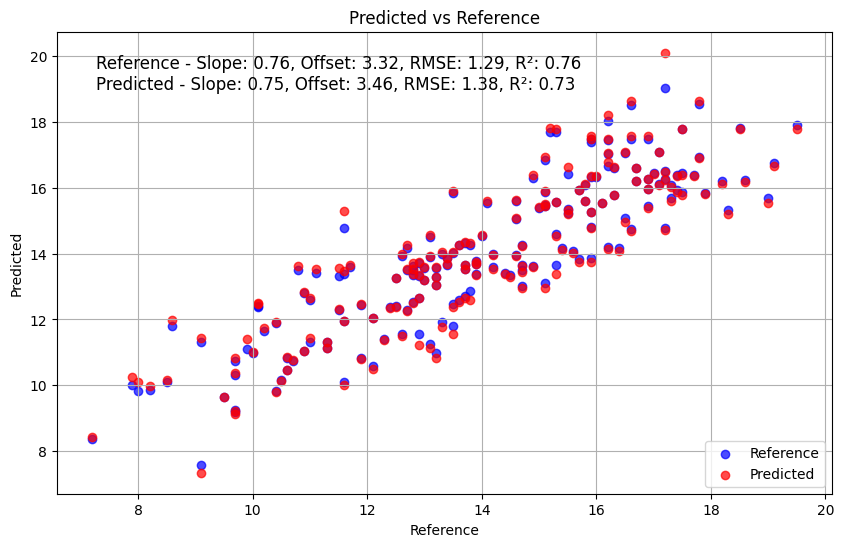

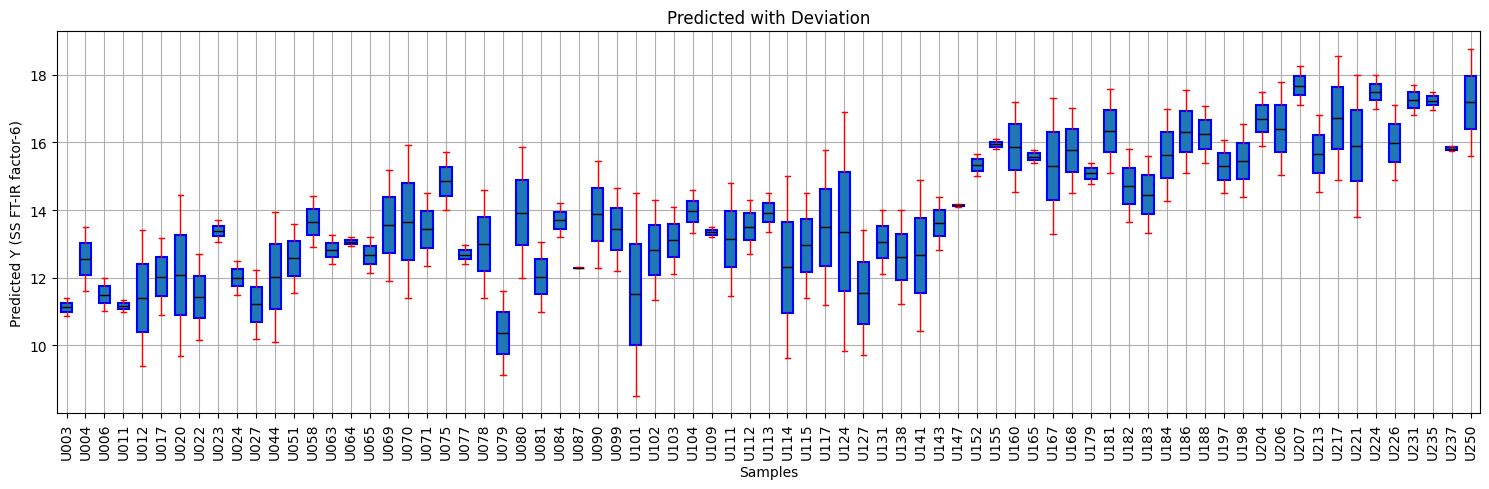

In [10]:
calibration_msc_sst, validation_msc_sst, Y_predict_msc_sst = build_model(df_msc_cal, df_msc_cal['SST'], df_msc_val, df_msc_val['SST'])


## SNV - PLSR

## SG - PLSR

# Teste